In [5]:
import pylab
import imageio
import numpy as np
from skimage.util import pad, crop
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
filename = 'data/test2.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

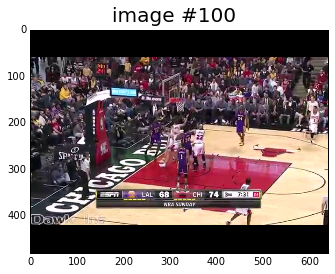

In [16]:
nums = [100,]
for num in nums:
    image = vid.get_data(num)
    image = pad(image,((60,60),(0,0),(0,0)),'constant')
    fig = plt.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    plt.imshow(image)

In [148]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

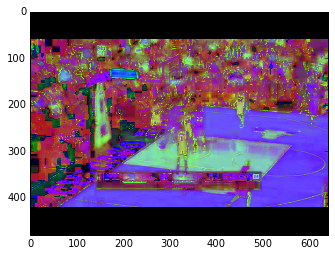

In [149]:
plt.imshow(img)

In [209]:
kobe = img[167:248,440:465]

In [210]:
hist_kobe = cv2.calcHist([kobe], [0], None, [256], [0,256])

In [211]:
rose = img[164:240,590:617]

In [212]:
hist_rose = cv2.calcHist([rose], [0], None, [256], [0,256])

In [213]:
rose[:,:,0]

array([[ 96,  96, 109, ..., 127, 127, 127],
       [ 96,  96, 109, ..., 127, 127, 127],
       [105, 110, 116, ..., 130, 130, 127],
       ..., 
       [104, 104, 105, ..., 105, 105, 105],
       [101, 103, 104, ..., 105, 105, 105],
       [102, 103, 104, ..., 105, 105, 105]], dtype=uint8)

In [214]:
(167,189,104)

(167, 189, 104)

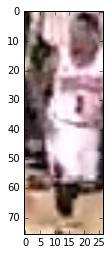

In [225]:
plt.imshow(image[164:240,590:617])

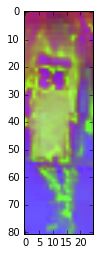

In [215]:
plt.imshow(kobe)

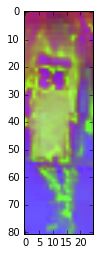

In [218]:
plt.imshow(kobe[:],'Greys')

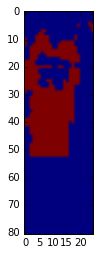

In [245]:
ORANGE_MIN = np.array([140, 100, 5],np.uint8)
ORANGE_MAX = np.array([200, 255, 255],np.uint8)
# ORANGE_MIN = np.array([0, 20, 0],np.uint8)
# ORANGE_MAX = np.array([255, 50, 255],np.uint8)

# 59,24,106
frame_threshed = cv2.inRange(kobe, ORANGE_MIN, ORANGE_MAX)
plt.imshow(frame_threshed)

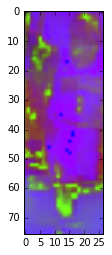

In [219]:
plt.imshow(rose[:],'Greys')

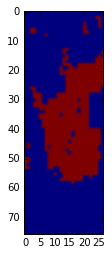

In [247]:
ORANGE_MIN = np.array([130, 0, 100],np.uint8)
ORANGE_MAX = np.array([150, 100, 255],np.uint8)

frame_threshed = cv2.inRange(img[164:240,590:617], ORANGE_MIN, ORANGE_MAX)
plt.imshow(frame_threshed)

In [355]:
boxes = [(341.5, 211.5, 362.5, 280.5),
 (307.5, 231.5, 328.5, 296.5),
 (440.5, 167.5, 465.5, 248.5),
 (590.5, 164.0, 617.5, 240.0),
 (443.0, 332.0, 469.0, 414.0),
 (307.0, 215.5, 323.0, 278.5)]

In [451]:
def color_percentage(boxes):
    classification = []
    for box in boxes:
        WHITE_MIN = np.array([130, 0, 100],np.uint8)
        WHITE_MAX = np.array([150, 100, 255],np.uint8)

        PURPLE_MIN = np.array([140, 100, 5],np.uint8)
        PURPLE_MAX = np.array([200, 255, 255],np.uint8)

        white_threshed = cv2.inRange(img[box[1]:box[3],box[0]:box[2]], WHITE_MIN, WHITE_MAX)
        purple_threshed = cv2.inRange(img[box[1]:box[3],box[0]:box[2]], PURPLE_MIN, PURPLE_MAX)
        total = float(255*(box[3]-box[1])*(box[2]-box[0]))
        white_ratio = np.sum(white_threshed)/total
        purple_ratio = np.sum(purple_threshed)/total
        classification.append((white_ratio,purple_ratio))

    return classification

In [526]:
def box_overlap(boxes):
    overlap = []
    for i, box in enumerate(boxes):
        sublist = boxes[i+1:]
        box_set = set([])
        for j, subbox in enumerate(sublist):
            x = min(box[2],subbox[2]) - max(box[0],subbox[0])
            y = min(box[3],subbox[3]) - max(box[1],subbox[1])
            if x > 0 and y > 0:
#                 area = x * y
#                 a.append(area)
                box_set.add(i)
                box_set.add(i+1+j)
        if box_set:
            overlap.append(box_set)
    return overlap

In [527]:
test = box_overlap(boxes)

In [528]:
boxes

[(341.5, 211.5, 362.5, 280.5),
 (307.5, 231.5, 328.5, 296.5),
 (440.5, 167.5, 465.5, 248.5),
 (590.5, 164.0, 617.5, 240.0),
 (443.0, 332.0, 469.0, 414.0),
 (307.0, 215.5, 323.0, 278.5)]

In [534]:
def team_classify(boxes):
    colors = color_percentage(boxes)
    overlaps = box_overlap(boxes) 

    team = []
    over = [{1:0,2:0,3:0}]*len(overlaps)
    
    for i, color in enumerate(colors):
        white, purple = color
        if white < .01 and purple < .01:
            team.append(-1)
        else:
            if white - purple > .1:
                team.append(1)
            elif purple - white > .1:
                team.append(2)
            else:
                team.append(3)
    for ind, group in enumerate(overlaps):
        for temp in group:
            over[ind][team[temp]] = over[ind][team[temp]] + 1
    for i, val in enumerate(team):
        if val == 3:
            for ind, group in enumerate(overlaps):
                if i in group:
                    if over[ind][1] > over[ind][2]:
                        team[i] = 2
                        over[ind][2] = over[ind][2] + 1
                    elif over[ind][1] < over[ind][2]:
                        team[i] = 1
                        over[ind][1] = over[ind][1] + 1
    return team    

In [535]:
test = team_classify(boxes)

[{1: 1, 2: 1, 3: 1}]


/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [531]:
test

[1, 2, 2, 1, 1, 1]

In [432]:
a = []

In [419]:
boxes = list()

TypeError: 'int' object is not iterable

In [346]:
boxes.remove(boxes[1])

In [370]:
boxes[1][2]-boxes[0][0]

-13.0

In [371]:
boxes[0][2]-boxes[1][0]

55.0

In [365]:
[x-y for x, y in zip(boxes[0],boxes[1])]

[34.0, -20.0, 34.0, -16.0]

In [363]:
boxes[0]

(341.5, 211.5, 362.5, 280.5)

In [ ]:
def b(boxes, classification):
    

In [343]:
classification

[(0.44444444444444442, 0.097308488612836433),
 (0.25494505494505493, 0.26227106227106228),
 (0.050370370370370371, 0.29432098765432096),
 (0.31725146198830412, 0.0),
 (0.23358348968105067, 0.001876172607879925),
 (0.39880952380952384, 0.12400793650793651)]

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


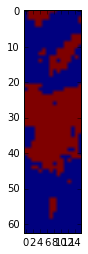

In [337]:
box = boxes[5]
ORANGE_MIN = np.array([130, 0, 100],np.uint8)
ORANGE_MAX = np.array([150, 100, 255],np.uint8)
plt.imshow(img[box[1]:box[3],box[0]:box[2]])
frame_threshed = cv2.inRange(img[box[1]:box[3],box[0]:box[2]], ORANGE_MIN, ORANGE_MAX)
plt.imshow(frame_threshed)

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


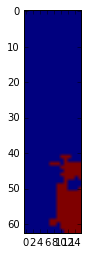

In [338]:
ORANGE_MIN = np.array([140, 100, 5],np.uint8)
ORANGE_MAX = np.array([200, 255, 255],np.uint8)
plt.imshow(img[box[1]:box[3],box[0]:box[2]])
frame_threshed = cv2.inRange(img[box[1]:box[3],box[0]:box[2]], ORANGE_MIN, ORANGE_MAX)
plt.imshow(frame_threshed)

In [339]:
np.sum(frame_threshed)

31875

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


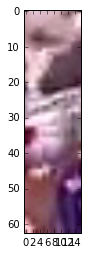

In [340]:
plt.imshow(image[box[1]:box[3],box[0]:box[2]])